In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import h5py
from kerneldmd.kernels import *
from kerneldmd.kernels import _dist_matrix, _scal_matrix
from kerneldmd.eig_tools import companion_matrix
from itertools import combinations
from scipy.stats import gaussian_kde
import ipywidgets as widgets
import mdtraj as md
import pylops
#Paranoia
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
__useTeX__ = True
if __useTeX__:
    plt.rcParams.update({
        "text.usetex": False,
        "mathtext.fontset": "cm",
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"]
    })
from kerneldmd.eiscor_wrapper.complex_double.z_poly_roots import z_poly_roots

### Load data

In [3]:
def print_attrs(name, obj):
    print(name)
    for key, val in obj.attrs.items():
        print (f"    {key}: {val}")
chignolin_path = '../data/md_datasets/chignolin-unbiased/CLN025-0-protein-ALL.h5'
f = h5py.File(chignolin_path, 'r')
#    for key, val in f.attrs.items():
#        print (f"{key}: {val}")
#    f.visititems(print_attrs)

In [4]:
traj = md.load_hdf5(chignolin_path)
pairs = list(combinations(traj.top.select("symbol != H"), 2))
distances = md.compute_distances(traj, pairs)

In [5]:
start = 100000
stop = len(traj)
num_steps = 1000
n_frames = len(traj)
stride = int((stop-start)/num_steps)
centers = distances[start:stop:stride,:]
test_pts = distances[::50,:]

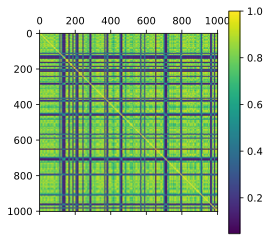

In [6]:
l = 20
nu = 1.5
kernel = lambda *X: Matern(*X, nu=nu, l=l) 
K_full = kernel(centers)
plt.matshow(K_full)
plt.colorbar()

In [7]:
n = K_full.shape[0] - 1
K = K_full[:-1, :-1] 
K_T = K_full[-1,:-1]
L = np.linalg.cholesky(K)
U = L.T
beta = np.linalg.solve(L, K_T)
Aop = pylops.MatrixMult(U)

In [8]:
eps = 0.05
maxit = 5000
#res = pylops.optimization.sparsity.FISTA(Aop, beta, maxit, eps=eps, tol=1e-3, returninfo=True)
#alpha_ista = res[0]
alpha_l2 = np.linalg.solve(K, K_T)
#S = companion_matrix(alpha_ista)

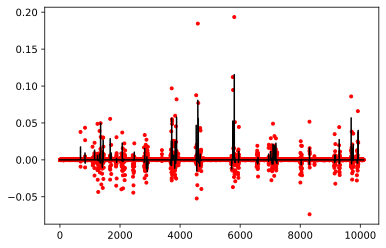

In [39]:
plt.plot(alpha_l2, 'r.')
plt.plot(alpha_ista, 'k-')

In [24]:
first = 0
last = 0
idx = 0
while np.abs(alpha_ista[idx]) < 1e-10:
    idx += 1
first = idx
idx = 1
while np.abs(alpha_ista[-idx]) < 1e-10:
    idx += 1
last = alpha_ista.shape[0] - idx

In [9]:
n = alpha_l2.shape[0] + 1
coeffs = np.zeros(n, dtype=np.complex128)
coeffs[0] = 1
coeffs[1:] = -alpha_l2[::-1]
roots = np.empty(n-1, dtype=np.complex128)
residuals = np.empty(n-1, dtype=np.float64)
info = 0
z_poly_roots(coeffs, roots, residuals, info)

In [10]:
L_vecs = np.vander(roots, increasing=True)

Text(0, 0.5, '$\\rm{Im}\\, \\lambda$')

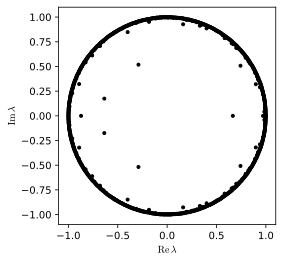

In [11]:
figure, axes = plt.subplots()
axes.set_aspect(1)
axes.plot(np.real(roots), np.imag(roots), 'k.')
axes.set_xlabel(r'$\rm{Re}\, \lambda$')
axes.set_ylabel(r'$\rm{Im}\, \lambda$')

Text(0, 0.5, '$\\rm{Im}\\, \\lambda$')

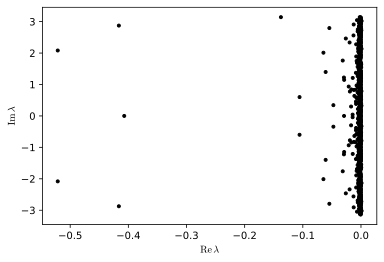

In [12]:
figure, axes = plt.subplots()
#axes.set_aspect(1)
axes.plot(np.real(np.log(roots)), np.imag(np.log(roots)), 'k.')
axes.set_xlabel(r'$\rm{Re}\, \lambda$')
axes.set_ylabel(r'$\rm{Im}\, \lambda$')

In [13]:
np.angle(roots)

array([ 0.5282506 ,  0.52151052,  0.51632621, ...,  3.14159265,
        2.87388162, -2.87388162])

In [44]:
Phi = kernel(centers[:-1],  test_pts)

In [47]:
a = np.linalg.norm(L_vecs.T)

In [48]:
CVs = np.linalg.solve(L_vecs.T*a, Phi)

In [49]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca_CVs = pca.fit_transform(np.abs(CVs.T))

In [50]:
1 - np.sum(pca.explained_variance_ratio_)

0.009353510956056965

In [51]:
def f(x):
    kde = gaussian_kde(pca_CVs[:,x])
    bounds = (pca_CVs[:,x].min(),pca_CVs[:,x].max())
    padding = 0
    cv_sample = np.linspace(bounds[0] - padding, bounds[1] + padding, 200)
    #print(kde.factor)
    plt.plot(cv_sample, -kde.logpdf(cv_sample), 'k-')
    plt.margins(0)
    plt.xlabel(f"Kernel_DMD_{x}")
    plt.ylabel(r"Fes $[K_{\rm{B}}T]$")
    plt.text(0.01, 0.95, f"Explained variance: {np.around(pca.explained_variance_ratio_[x]*100,decimals=1)}%", horizontalalignment='left',
     verticalalignment='center',
     transform = plt.gca().axes.transAxes)
    print(kde.factor)
widgets.interact(f, x=widgets.IntSlider(min=0, max=pca_CVs.shape[1] - 1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='x', max=4), Output()), _dom_classes=('widget-interact',)…

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stateinterpreter import Classifier, identify_metastable_states, load_dataframe, descriptors_from_traj, sample
from stateinterpreter.plot import plot_states, plot_combination_states_features
from stateinterpreter.visualize import visualize_features

In [53]:
chignolin_data_path = '../data/md_datasets/chignolin-unbiased/'
traj_dict = {
        'trajectory' : chignolin_data_path+'CLN025-0-protein-ALL.dcd',
        'topology' : chignolin_data_path+'CLN025-0-protein.pdb'
    }
stride = 50
#Compute descriptors
descriptors, feats_info = descriptors_from_traj(traj_dict, descriptors=['hbonds_contacts'], stride=stride)

Computing Hydrogen bonds contacts
Donors: [0, 15, 23, 36, 44, 70, 85, 91, 99, 106, 112, 120, 130, 147, 160]
Acceptors: [  0  15  22  23  36  43  44  52  53  55  56  69  70  81  82  84  85  91
  98  99 105 106 112 119 120 130 143 145 146 147 160]
Descriptors: (10495, 318)


In [54]:
import pandas as pd
col_names = [f"Kernel_DMD_{idx}" for idx in range(pca_CVs.shape[1])]
colvars = pd.DataFrame(pca_CVs, columns=col_names)

In [55]:
cv_list = ["Kernel_DMD_0","Kernel_DMD_1"]#, "Kernel_DMD_2"]
kBT = 2.8
states_labels = identify_metastable_states(colvars, cv_list, kBT, fes_cutoff=0.5*kBT, bw_method=0.25, optimizer_kwargs={'num_init' : 200})

DEV >>> Finding Local Minima


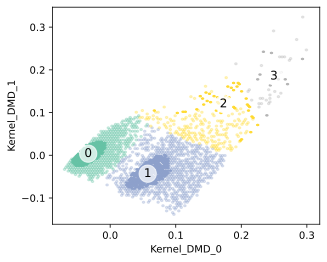

In [45]:
plot_states(colvars, states_labels, cv_list)

In [154]:
main_color = ['k', 'red', 'blue']
mask = states_labels['selection'].to_numpy()
colors = np.array([main_color[label] for label in states_labels['labels']])

In [155]:
plt.scatter(np.arange(len(colors)), colvars[cv_list[0]], c='k', s=0.5, alpha=0.2)
plt.scatter(np.arange(len(colors))[mask], colvars[cv_list[0]][mask], c=colors[mask], s=0.5)

Optimizing Lasso Estimator: 100%|██████████| 25/25 [00:00<00:00, 132.17it/s]


Accuracy: 100%
State 0:
[99.619%]  HB_CONTACT TYR1-O -- TYR10-N
[0.381% ]  HB_CONTACT ASP3-N -- THR8-O
State 1:
[99.619%]  HB_CONTACT TYR1-O -- TYR10-N
[0.381% ]  HB_CONTACT ASP3-N -- THR8-O


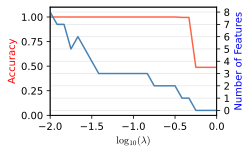

In [46]:
sample_obj, features_names, classes_names = sample(descriptors, states_labels, 500, states_subset=[0,1])
regularizers = np.geomspace(0.01, 1, 25)
classifier = Classifier(sample_obj, features_names, classes_names)
classifier.compute(regularizers, max_iter= 10000, quadratic_kernel=False)
classifier.plot();
reg = 10**(-0.5)
classifier.print_selected(reg)

In [164]:
visualize_features(traj[::stride], states_labels, classifier.classes, classifier._get_selected(reg), feats_info, state=0)

NGLWidget(max_frame=1)